In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import statsmodels.formula.api as smf
from sklearn import linear_model

In [3]:
pd.set_option("display.max_columns", 40)
print(pd.get_option("display.max_columns"))
print(pd.get_option("display.max_rows"))

40
60


### Load MapAffil data
    - where FIPS is not null

In [251]:
iter_csv = pd.read_table('./data/mapAffil_2016_nonull.tsv', sep='\t', encoding='latin-1',
                         dtype={'PMID': object, 
                                'au_order': np.int64, 
                                'year': np.int64,
                                'type': object, 
                                'city': object, 
                                'state':object, 
                                'country': object,
                                'lat': np.float64, 
                                'lon': np.float64, 
                                'fips': object},
                         iterator=True, chunksize=10**6)
mapAffil = pd.concat([chunk[pd.notnull(chunk['fips'])] for chunk in iter_csv])



In [253]:
# drop index column
mapAffil = mapAffil.drop(['Unnamed: 0'], 1)
#strip leading 0s on fips
#mapAffil['fips'] = mapAffil['fips'].str.lstrip('0')

In [254]:
print(mapAffil.shape)
mapAffil.dtypes

(12191076, 10)


PMID         object
au_order      int64
year          int64
type         object
city         object
state        object
country      object
lat         float64
lon         float64
fips         object
dtype: object

In [252]:
mapAffil.head()

,Unnamed: 0,PMID,au_order,year,type,city,state,country,lat,lon,fips
0,0,26151952,1,2016,EDU,"Tucson, AZ, USA",AZ,USA,32.222,-110.970,04019
1,1,26151951,1,2016,EDU,"Los Angeles, CA, USA",CA,USA,34.053,-118.245,06037
2,2,26151950,1,2016,EDU,"Manhattan, New York, NY, USA",NY,USA,40.790,-73.960,36061
3,3,26151925,3,2015,EDU-HOS,"Boston, MA, USA",MA,USA,42.359,-71.057,25025
4,4,26151913,8,2015,ORG,"San Francisco, CA, USA",CA,USA,37.779,-122.420,06075


In [255]:
mapAffil[mapAffil['fips'] == '01001']

,PMID,au_order,year,type,city,state,country,lat,lon,fips
757983,1639703,1,1992,HOS,"Prattville, AL, USA",AL,USA,32.462,-86.451,01001
814313,1293126,1,1992,HOS,"Prattville, AL, USA",AL,USA,32.462,-86.451,01001
131206,26914462,7,2016,UNK,"Prattville, AL, USA",AL,USA,32.462,-86.451,01001


### Load mortality data
   - some ```population```, ```count``` values are "Missing"
   - treat differently from rate NaNs?

In [256]:
mort = pd.read_table('./data/mortality.tsv',sep='\t', encoding='latin-1', na_values='Missing',
                    dtype={'fips': object})

In [257]:
print(mort.shape)
mort.dtypes

(36975, 19)


fips       object
cause      object
metric     object
Y1999     float64
Y2000     float64
Y2001     float64
Y2002     float64
Y2003     float64
Y2004     float64
Y2005     float64
Y2006     float64
Y2007     float64
Y2008     float64
Y2009     float64
Y2010     float64
Y2011     float64
Y2012     float64
Y2013     float64
Y2014     float64
dtype: object

In [ ]:
#strip leading 0s on fips code
#mort['fips'] = mort['fips'].str.lstrip('0')

In [258]:
mort.head()

,fips,cause,metric,Y1999,Y2000,Y2001,Y2002,Y2003,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014
0,01001,all,count,361.00000,356.00000,362.00000,388.00000,400.00000,377.00000,454.00000,457.00000,406.00000,457.00000,412.00000,433.00000,456.00000,514.00000,535.00000,482.00000
1,01001,all,rate,1064.73351,1021.78792,1008.79702,1037.62083,1038.44489,934.52341,1123.39499,1073.07450,906.71136,975.42381,854.73234,889.28022,889.96525,974.63061,986.88348,853.04754
2,01001,circulatory,count,134.00000,148.00000,147.00000,134.00000,142.00000,126.00000,181.00000,153.00000,139.00000,150.00000,152.00000,155.00000,160.00000,161.00000,175.00000,153.00000
3,01001,circulatory,rate,416.27091,433.90861,430.72231,378.62585,399.39245,317.35597,460.14642,371.17933,331.90294,329.45564,331.58747,324.32511,314.45203,320.74459,335.76660,278.23161
4,01001,mental,count,NaN,NaN,NaN,10.00000,NaN,NaN,11.00000,14.00000,14.00000,16.00000,NaN,24.00000,20.00000,18.00000,17.00000,17.00000


In [229]:
mort.cause.unique()

array(['all', 'circulatory', 'mental', 'neoplasms', 'nervous',
       'population', 'respiratory'], dtype=object)

In [230]:
mort.metric.unique()

array(['count', 'rate'], dtype=object)

In [231]:
# CU mortality rates
mort[mort.fips == '17019']

,fips,cause,metric,Y1999,Y2000,Y2001,Y2002,Y2003,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014
7099,17019,all,count,1056.00000,1110.00000,1243.00000,1158.00000,1191.00000,1196.00000,1219.00000,1129.00000,1118.00000,1148.00000,1192.00000,1124.00000,1219.00000,1158.00000,1243.00000,1301.00000
7100,17019,all,rate,752.02095,775.12810,848.95169,777.16701,788.56846,767.84010,778.95154,696.86922,674.82351,674.46888,695.19423,646.37757,688.96508,632.58483,651.76888,683.03939
7101,17019,circulatory,count,403.00000,378.00000,417.00000,381.00000,430.00000,397.00000,379.00000,354.00000,338.00000,350.00000,317.00000,312.00000,364.00000,313.00000,374.00000,371.00000
7102,17019,circulatory,rate,289.83920,265.73027,287.53638,259.20879,285.31676,258.23447,244.10397,218.16803,204.64849,205.77647,184.66193,179.54713,204.83396,170.08638,192.77718,193.46873
7103,17019,mental,count,13.00000,NaN,17.00000,20.00000,29.00000,37.00000,27.00000,40.00000,40.00000,41.00000,47.00000,50.00000,57.00000,57.00000,84.00000,85.00000
7104,17019,mental,rate,NaN,NaN,NaN,12.96565,19.08889,23.46429,16.87611,24.14345,23.86674,23.45318,26.16518,29.22559,30.62000,29.78486,42.87553,44.11485
7105,17019,neoplasms,count,253.00000,291.00000,326.00000,303.00000,295.00000,289.00000,294.00000,251.00000,274.00000,265.00000,279.00000,268.00000,282.00000,281.00000,261.00000,300.00000
7106,17019,neoplasms,rate,182.20000,207.40000,228.10000,207.50000,198.50000,189.40000,190.20000,159.30000,168.80000,158.30000,164.60000,156.60000,165.00000,156.60000,140.90000,160.50000
7107,17019,nervous,count,62.00000,65.00000,67.00000,60.00000,57.00000,67.00000,75.00000,67.00000,73.00000,76.00000,93.00000,82.00000,95.00000,94.00000,68.00000,78.00000
7108,17019,nervous,rate,43.91956,46.02099,44.65371,40.08084,37.80478,43.17905,48.63822,40.77429,43.23695,44.37406,54.44946,47.30975,52.07591,50.33563,36.27060,39.87881


### Plot mortality rates - all categories

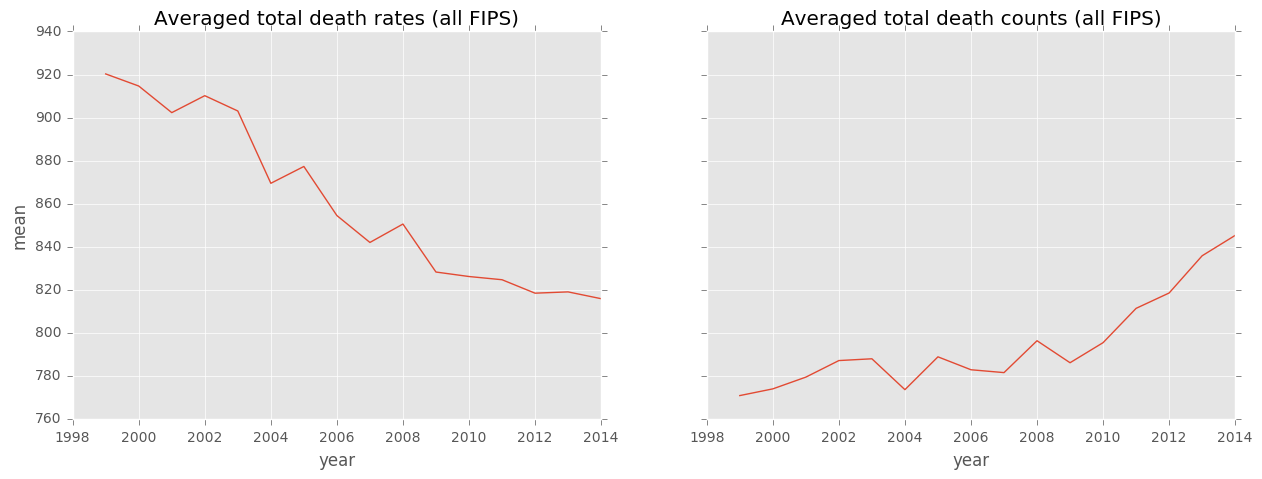

In [259]:
year_cols = list(mort.columns[3:])

# averages of cause="all" metric="rate"
all_rate = mort.loc[(mort.cause == 'all') & (mort.metric == 'rate'), year_cols]
all_count = mort.loc[(mort.cause == 'all') & (mort.metric == 'count'), year_cols]

means = []
years = []
for column in all_rate:
    name = all_rate[column].name
    year = name[1:]
    mean = all_rate[column].mean(skipna=True)
    means.append(mean)
    years.append(year)
    # print(name, mean)

# averages of cause="all" metric="count"
counts = []
for column in all_count:
    name = all_count[column].name
    year = name[1:]
    avgs = all_count[column].mean(skipna=True)
    counts.append(avgs)
    # years.append(year)
    # print(name, sums)

    

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,5))
ax1.plot(years,means)
ax1.set_title("Averaged total death rates (all FIPS)")
ax1.set_ylabel('mean')
ax1.set_xlabel('year')
ax2.plot(years, counts)
ax2.set_title("Averaged total death counts (all FIPS)")
#ax2.set_ylabel('mean')
ax2.set_xlabel('year')
    
# plt.plot(years, means)
# plt.ylabel('average total death rate')
# plt.xlabel('year')
plt.show()

---
### Reshape mortality data
- create single ```rate``` column

In [272]:
mort_rate = mort.loc[(mort.metric == 'rate')]
print(mort.shape)
print(mort_rate.shape)
mort_rate.head()
# mort.loc[(mort.metric == 'rate') & (mort.isnull().any(axis=1) == False)]

(36975, 19)
(16914, 19)


,fips,cause,metric,Y1999,Y2000,Y2001,Y2002,Y2003,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014
1,01001,all,rate,1064.73351,1021.78792,1008.79702,1037.62083,1038.44489,934.52341,1123.39499,1073.07450,906.71136,975.42381,854.73234,889.28022,889.96525,974.63061,986.88348,853.04754
3,01001,circulatory,rate,416.27091,433.90861,430.72231,378.62585,399.39245,317.35597,460.14642,371.17933,331.90294,329.45564,331.58747,324.32511,314.45203,320.74459,335.76660,278.23161
5,01001,mental,rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.35239,46.10632,NaN,NaN,NaN
7,01001,neoplasms,rate,264.50000,224.90000,178.20000,238.80000,171.00000,222.90000,202.60000,264.00000,193.50000,241.20000,165.80000,163.50000,144.60000,224.00000,208.20000,166.60000
9,01001,nervous,rate,NaN,NaN,NaN,NaN,70.70183,68.36369,68.19907,NaN,NaN,NaN,NaN,NaN,53.48213,NaN,45.77361,55.55558


In [273]:
mort_expanded = mort_rate.drop(labels='metric', axis=1)
print(mort_expanded.shape)
mort_expanded.head()

(16914, 18)


,fips,cause,Y1999,Y2000,Y2001,Y2002,Y2003,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014
1,01001,all,1064.73351,1021.78792,1008.79702,1037.62083,1038.44489,934.52341,1123.39499,1073.07450,906.71136,975.42381,854.73234,889.28022,889.96525,974.63061,986.88348,853.04754
3,01001,circulatory,416.27091,433.90861,430.72231,378.62585,399.39245,317.35597,460.14642,371.17933,331.90294,329.45564,331.58747,324.32511,314.45203,320.74459,335.76660,278.23161
5,01001,mental,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.35239,46.10632,NaN,NaN,NaN
7,01001,neoplasms,264.50000,224.90000,178.20000,238.80000,171.00000,222.90000,202.60000,264.00000,193.50000,241.20000,165.80000,163.50000,144.60000,224.00000,208.20000,166.60000
9,01001,nervous,NaN,NaN,NaN,NaN,70.70183,68.36369,68.19907,NaN,NaN,NaN,NaN,NaN,53.48213,NaN,45.77361,55.55558


In [274]:
# Don't run twice!
mort_expanded.index.name = 'original'
mort_expanded.set_index(['fips', 'cause'], append=True, inplace=True)
mort_expanded = mort_expanded.reorder_levels(['original','fips', 'cause'])

In [275]:
# .stack() removes NaN value rows
mort_expanded.stack()

original  fips   cause             
1         01001  all          Y1999    1064.73351
                              Y2000    1021.78792
                              Y2001    1008.79702
                              Y2002    1037.62083
                              Y2003    1038.44489
                              Y2004     934.52341
                              Y2005    1123.39499
                              Y2006    1073.07450
                              Y2007     906.71136
                              Y2008     975.42381
                              Y2009     854.73234
                              Y2010     889.28022
                              Y2011     889.96525
                              Y2012     974.63061
                              Y2013     986.88348
                              Y2014     853.04754
3         01001  circulatory  Y1999     416.27091
                              Y2000     433.90861
                              Y2001     430.72231
              

In [276]:
mort_expanded = mort_expanded.stack().to_frame().reset_index()
mort_expanded.head()

,original,fips,cause,level_3,0
0,1,01001,all,Y1999,1064.73351
1,1,01001,all,Y2000,1021.78792
2,1,01001,all,Y2001,1008.79702
3,1,01001,all,Y2002,1037.62083
4,1,01001,all,Y2003,1038.44489


In [277]:
mort_expanded = mort_expanded.rename(columns={"level_3":"year", 0:"rate"})

In [278]:
# Don't run twice
mort_expanded.year = mort_expanded.year.str[1:]
mort_expanded['year'] = pd.to_numeric(mort_expanded['year'])
mort_expanded = mort_expanded.drop(labels=['original'], axis=1)
mort_expanded.dtypes

original      int64
fips         object
cause        object
year          int64
rate        float64
dtype: object

In [369]:
print(mort_expanded.shape)
mort_expanded.head()

(197401, 4)


,fips,cause,year,rate
0,01001,all,1999,1064.73351
1,01001,all,2000,1021.78792
2,01001,all,2001,1008.79702
3,01001,all,2002,1037.62083
4,01001,all,2003,1038.44489


---
### Create MapAffil publication columns
- count number of distinct PMIDs per fips per year

In [357]:
count_PMID_by_year_fips = mapAffil.groupby(['fips', 'year'])['PMID'].nunique()


In [358]:
count_PMID_by_year_fips.head()

fips   year
01001  1992    2
       2016    1
01003  1989    1
       1990    1
       1993    1
Name: PMID, dtype: int64

In [363]:
# Don't run twice!
count_PMID_by_year_fips = pd.DataFrame(count_PMID_by_year_fips).reset_index()
count_PMID_by_year_fips = count_PMID_by_year_fips.rename(columns={'PMID': 'PMID_count'})
#count_PMID_by_year_fips = pd.DataFrame(count_PMID_by_year_fips)

In [364]:
count_PMID_by_year_fips.head()

,fips,year,PMID_count
0,01001,1992,2
1,01001,2016,1
2,01003,1989,1
3,01003,1990,1
4,01003,1993,1


In [349]:
# types_all = pd.merge(mapAffil.loc[:,['fips','year', 'type']], count_PMID_by_year_fips, right_index=True, left_on=['fips', 'year'], how='outer')
# types_all.head()

,fips,year,type,PMID_count
0,04019,2016,EDU,1941
10165,04019,2016,EDU,1941
10166,04019,2016,EDU,1941
10167,04019,2016,EDU,1941
10168,04019,2016,EDU,1941


In [346]:
# types_count = types_all.groupby(['fips', 'year', 'type']).agg({'type': len}).rename(columns={'type': 'type_count'})
# types_count.head()

type_count
fips  year type            
01001 1992 HOS            2
      2016 UNK            1
01003 1989 HOS            1
      1990 UNK            1
      1993 COM            1

In [347]:
# types_count = types_count.reset_index()

In [348]:
# # pivot years and pub count values
# types_count = pd.pivot_table(types_count, values='type_count', index=['fips', 'year'], columns=['type'])
# types_count.head()

type        COM  EDU  EDU-HOS  GOV  HOS  MIL  ORG  UNK
fips  year                                            
01001 1992  NaN  NaN      NaN  NaN  2.0  NaN  NaN  NaN
      2016  NaN  NaN      NaN  NaN  NaN  NaN  NaN  1.0
01003 1989  NaN  NaN      NaN  NaN  1.0  NaN  NaN  NaN
      1990  NaN  NaN      NaN  NaN  NaN  NaN  NaN  1.0
      1993  1.0  NaN      NaN  NaN  NaN  NaN  NaN  NaN

In [ ]:
# types_count = types_count.reset_index()
# pd.merge(mapAffil.loc[:,['fips','year', 'type']], count_PMID_by_year_fips, right_index=True, left_on=['fips', 'year'], how='outer')

In [366]:
mort_pubs.head()

,fips,year,type,city,lat,lon,PMID_count
0,04019,2016,EDU,"Tucson, AZ, USA",32.222,-110.97,1941
10165,04019,2016,EDU,"Tucson, AZ, USA",32.222,-110.97,1941
10166,04019,2016,EDU,"Tucson, AZ, USA",32.222,-110.97,1941
10167,04019,2016,EDU,"Tucson, AZ, USA",32.222,-110.97,1941
10168,04019,2016,EDU,"Tucson, AZ, USA",32.222,-110.97,1941


In [352]:
mort_pubs.type.unique()

array(['EDU', 'EDU-HOS', 'COM', 'UNK', 'ORG', 'HOS', 'GOV', 'MIL'], dtype=object)

In [305]:
mapAffil.head()

,PMID,au_order,year,type,city,state,country,lat,lon,fips
0,26151952,1,2016,EDU,"Tucson, AZ, USA",AZ,USA,32.222,-110.970,04019
1,26151951,1,2016,EDU,"Los Angeles, CA, USA",CA,USA,34.053,-118.245,06037
2,26151950,1,2016,EDU,"Manhattan, New York, NY, USA",NY,USA,40.790,-73.960,36061
3,26151925,3,2015,EDU-HOS,"Boston, MA, USA",MA,USA,42.359,-71.057,25025
4,26151913,8,2015,ORG,"San Francisco, CA, USA",CA,USA,37.779,-122.420,06075


In [220]:
# city_fips = mapAffil.loc[:,['city','fips']].drop_duplicates()
# print(city_fips.shape)
# city_fips.head()

(6850, 2)


,city,fips
0,"Tucson, AZ, USA",04019
1,"Los Angeles, CA, USA",06037
2,"Manhattan, New York, NY, USA",36061
3,"Boston, MA, USA",25025
4,"San Francisco, CA, USA",06075


#### transpose columns
- pivot years and publication count values
- drop years before 1988

In [371]:
# pivot years and pub count values
years_pubs = pd.pivot_table(count_PMID_by_year_fips, values='PMID_count', index=['fips'], columns=['year'])
print(years_pubs.shape)
#print(years_pubs.columns)

### drop years before 1988
drop_yrs = []
for col in years_pubs.iloc[:,:]:
    if years_pubs[col].name < 1988:
        drop_yrs.append(years_pubs[col].name)

#print(drop_yrs)


years_pubs = years_pubs.drop(labels=drop_yrs, axis=1)

print(years_pubs.columns)
# print(years_pubs.index)
print(years_pubs.shape)
years_pubs.head()

(2054, 139)
Int64Index([1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
            1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
            2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
           dtype='int64', name='year')
(2054, 30)


year,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
fips,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01001,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
01003,NaN,1.0,1.0,NaN,NaN,1.0,1.0,2.0,2.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,2.0,4.0,1.0,2.0,2.0,5.0,5.0,4.0,7.0,5.0,NaN
01015,NaN,1.0,2.0,NaN,4.0,3.0,1.0,2.0,1.0,NaN,2.0,NaN,NaN,2.0,2.0,4.0,1.0,3.0,5.0,4.0,6.0,3.0,4.0,3.0,4.0,3.0,7.0,6.0,12.0,NaN
01017,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
01021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### format column headers

In [372]:
years_pubs_headers = {}
for col in years_pubs.iloc[:,:]:
    year = years_pubs[col].name
    name = '{0}{1}'.format('pubs_', str(year))
    years_pubs_headers[year] = name
# print(years_pubs_headers)

# map new column names
years_pubs = years_pubs.rename(columns = years_pubs_headers)

years_pubs.head()

year,pubs_1988,pubs_1989,pubs_1990,pubs_1991,pubs_1992,pubs_1993,pubs_1994,pubs_1995,pubs_1996,pubs_1997,pubs_1998,pubs_1999,pubs_2000,pubs_2001,pubs_2002,pubs_2003,pubs_2004,pubs_2005,pubs_2006,pubs_2007,pubs_2008,pubs_2009,pubs_2010,pubs_2011,pubs_2012,pubs_2013,pubs_2014,pubs_2015,pubs_2016,pubs_2017
fips,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01001,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
01003,NaN,1.0,1.0,NaN,NaN,1.0,1.0,2.0,2.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,2.0,4.0,1.0,2.0,2.0,5.0,5.0,4.0,7.0,5.0,NaN
01015,NaN,1.0,2.0,NaN,4.0,3.0,1.0,2.0,1.0,NaN,2.0,NaN,NaN,2.0,2.0,4.0,1.0,3.0,5.0,4.0,6.0,3.0,4.0,3.0,4.0,3.0,7.0,6.0,12.0,NaN
01017,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
01021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [373]:
## Don't run twice!!
years_pubs = years_pubs.reset_index()
years_pubs.head()

year,fips,pubs_1988,pubs_1989,pubs_1990,pubs_1991,pubs_1992,pubs_1993,pubs_1994,pubs_1995,pubs_1996,pubs_1997,pubs_1998,pubs_1999,pubs_2000,pubs_2001,pubs_2002,pubs_2003,pubs_2004,pubs_2005,pubs_2006,pubs_2007,pubs_2008,pubs_2009,pubs_2010,pubs_2011,pubs_2012,pubs_2013,pubs_2014,pubs_2015,pubs_2016,pubs_2017
0,01001,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,01003,NaN,1.0,1.0,NaN,NaN,1.0,1.0,2.0,2.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,2.0,4.0,1.0,2.0,2.0,5.0,5.0,4.0,7.0,5.0,NaN
2,01015,NaN,1.0,2.0,NaN,4.0,3.0,1.0,2.0,1.0,NaN,2.0,NaN,NaN,2.0,2.0,4.0,1.0,3.0,5.0,4.0,6.0,3.0,4.0,3.0,4.0,3.0,7.0,6.0,12.0,NaN
3,01017,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
4,01021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [374]:
years_pubs.columns

Index(['fips', 'pubs_1988', 'pubs_1989', 'pubs_1990', 'pubs_1991', 'pubs_1992',
       'pubs_1993', 'pubs_1994', 'pubs_1995', 'pubs_1996', 'pubs_1997',
       'pubs_1998', 'pubs_1999', 'pubs_2000', 'pubs_2001', 'pubs_2002',
       'pubs_2003', 'pubs_2004', 'pubs_2005', 'pubs_2006', 'pubs_2007',
       'pubs_2008', 'pubs_2009', 'pubs_2010', 'pubs_2011', 'pubs_2012',
       'pubs_2013', 'pubs_2014', 'pubs_2015', 'pubs_2016', 'pubs_2017'],
      dtype='object', name='year')

In [375]:
mort_expanded.head()

,fips,cause,year,rate
0,01001,all,1999,1064.73351
1,01001,all,2000,1021.78792
2,01001,all,2001,1008.79702
3,01001,all,2002,1037.62083
4,01001,all,2003,1038.44489


In [377]:
years_pubs.head()

year,fips,pubs_1988,pubs_1989,pubs_1990,pubs_1991,pubs_1992,pubs_1993,pubs_1994,pubs_1995,pubs_1996,pubs_1997,pubs_1998,pubs_1999,pubs_2000,pubs_2001,pubs_2002,pubs_2003,pubs_2004,pubs_2005,pubs_2006,pubs_2007,pubs_2008,pubs_2009,pubs_2010,pubs_2011,pubs_2012,pubs_2013,pubs_2014,pubs_2015,pubs_2016,pubs_2017
0,01001,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,01003,NaN,1.0,1.0,NaN,NaN,1.0,1.0,2.0,2.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,2.0,4.0,1.0,2.0,2.0,5.0,5.0,4.0,7.0,5.0,NaN
2,01015,NaN,1.0,2.0,NaN,4.0,3.0,1.0,2.0,1.0,NaN,2.0,NaN,NaN,2.0,2.0,4.0,1.0,3.0,5.0,4.0,6.0,3.0,4.0,3.0,4.0,3.0,7.0,6.0,12.0,NaN
3,01017,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
4,01021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
### Merge mortality rates df and publication counts df on FIPS column
   - years columns?

In [388]:
mort_pubs = pd.merge(mort_expanded, years_pubs, on=['fips'], how='left')

In [389]:
mort_pubs.head()

,fips,cause,year,rate,pubs_1988,pubs_1989,pubs_1990,pubs_1991,pubs_1992,pubs_1993,pubs_1994,pubs_1995,pubs_1996,pubs_1997,pubs_1998,pubs_1999,pubs_2000,pubs_2001,pubs_2002,pubs_2003,pubs_2004,pubs_2005,pubs_2006,pubs_2007,pubs_2008,pubs_2009,pubs_2010,pubs_2011,pubs_2012,pubs_2013,pubs_2014,pubs_2015,pubs_2016,pubs_2017
0,01001,all,1999,1064.73351,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,01001,all,2000,1021.78792,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,01001,all,2001,1008.79702,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,01001,all,2002,1037.62083,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,01001,all,2003,1038.44489,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [390]:
pubs_cols = list(mort_pubs.columns.str.contains('pubs'))
pubs_cols = list(mort_pubs.columns[pubs_cols])
print(pubs_cols)

['pubs_1988', 'pubs_1989', 'pubs_1990', 'pubs_1991', 'pubs_1992', 'pubs_1993', 'pubs_1994', 'pubs_1995', 'pubs_1996', 'pubs_1997', 'pubs_1998', 'pubs_1999', 'pubs_2000', 'pubs_2001', 'pubs_2002', 'pubs_2003', 'pubs_2004', 'pubs_2005', 'pubs_2006', 'pubs_2007', 'pubs_2008', 'pubs_2009', 'pubs_2010', 'pubs_2011', 'pubs_2012', 'pubs_2013', 'pubs_2014', 'pubs_2015', 'pubs_2016', 'pubs_2017']


In [391]:
#Replace pubs NaNs with 0s
mort_pubs.loc[:,pubs_cols] = mort_pubs.loc[:,pubs_cols].fillna(0)
mort_pubs.head()

,fips,cause,year,rate,pubs_1988,pubs_1989,pubs_1990,pubs_1991,pubs_1992,pubs_1993,pubs_1994,pubs_1995,pubs_1996,pubs_1997,pubs_1998,pubs_1999,pubs_2000,pubs_2001,pubs_2002,pubs_2003,pubs_2004,pubs_2005,pubs_2006,pubs_2007,pubs_2008,pubs_2009,pubs_2010,pubs_2011,pubs_2012,pubs_2013,pubs_2014,pubs_2015,pubs_2016,pubs_2017
0,01001,all,1999,1064.73351,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,01001,all,2000,1021.78792,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,01001,all,2001,1008.79702,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,01001,all,2002,1037.62083,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,01001,all,2003,1038.44489,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [392]:
mort_pubs.dtypes

fips          object
cause         object
year           int64
rate         float64
pubs_1988    float64
pubs_1989    float64
pubs_1990    float64
pubs_1991    float64
pubs_1992    float64
pubs_1993    float64
pubs_1994    float64
pubs_1995    float64
pubs_1996    float64
pubs_1997    float64
pubs_1998    float64
pubs_1999    float64
pubs_2000    float64
pubs_2001    float64
pubs_2002    float64
pubs_2003    float64
pubs_2004    float64
pubs_2005    float64
pubs_2006    float64
pubs_2007    float64
pubs_2008    float64
pubs_2009    float64
pubs_2010    float64
pubs_2011    float64
pubs_2012    float64
pubs_2013    float64
pubs_2014    float64
pubs_2015    float64
pubs_2016    float64
pubs_2017    float64
dtype: object

In [395]:
pubs_cols = list(mort_pubs.columns.str.contains('pubs'))
pubs_cols = list(mort_pubs.columns[pubs_cols])
print(pubs_cols)

['pubs_1988', 'pubs_1989', 'pubs_1990', 'pubs_1991', 'pubs_1992', 'pubs_1993', 'pubs_1994', 'pubs_1995', 'pubs_1996', 'pubs_1997', 'pubs_1998', 'pubs_1999', 'pubs_2000', 'pubs_2001', 'pubs_2002', 'pubs_2003', 'pubs_2004', 'pubs_2005', 'pubs_2006', 'pubs_2007', 'pubs_2008', 'pubs_2009', 'pubs_2010', 'pubs_2011', 'pubs_2012', 'pubs_2013', 'pubs_2014', 'pubs_2015', 'pubs_2016', 'pubs_2017']


In [396]:
#Replace pubs NaNs with 0s
mort_pubs.loc[:,pubs_cols] = mort_pubs.loc[:,pubs_cols].fillna(0)
mort_pubs.head()

,fips,cause,year,rate,pubs_1988,pubs_1989,pubs_1990,pubs_1991,pubs_1992,pubs_1993,pubs_1994,pubs_1995,pubs_1996,pubs_1997,pubs_1998,pubs_1999,pubs_2000,pubs_2001,pubs_2002,pubs_2003,pubs_2004,pubs_2005,pubs_2006,pubs_2007,pubs_2008,pubs_2009,pubs_2010,pubs_2011,pubs_2012,pubs_2013,pubs_2014,pubs_2015,pubs_2016,pubs_2017
0,01001,all,1999,1064.73351,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,01001,all,2000,1021.78792,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,01001,all,2001,1008.79702,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,01001,all,2002,1037.62083,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,01001,all,2003,1038.44489,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [397]:
# write out to tsv file in data folder
# mort_pubs.to_csv('./data/mort_pubs.tsv', sep='\t')

---
### Start again here

In [495]:
mort_pubs = pd.read_table('./data/mort_pubs.tsv', sep='\t', encoding='latin-1',
                         dtype={'fips': object})

# drop first column
mort_pubs = mort_pubs.drop(['Unnamed: 0'], 1)

In [496]:
mort_pubs.dtypes

fips          object
cause         object
year           int64
rate         float64
pubs_1988    float64
pubs_1989    float64
pubs_1990    float64
pubs_1991    float64
pubs_1992    float64
pubs_1993    float64
pubs_1994    float64
pubs_1995    float64
pubs_1996    float64
pubs_1997    float64
pubs_1998    float64
pubs_1999    float64
pubs_2000    float64
pubs_2001    float64
pubs_2002    float64
pubs_2003    float64
pubs_2004    float64
pubs_2005    float64
pubs_2006    float64
pubs_2007    float64
pubs_2008    float64
pubs_2009    float64
pubs_2010    float64
pubs_2011    float64
pubs_2012    float64
pubs_2013    float64
pubs_2014    float64
pubs_2015    float64
pubs_2016    float64
pubs_2017    float64
dtype: object

---
### Fit linear regression line
  - sum across rows 
  - cumulative pub count for each ```fips```

In [8]:
# possible args are 
print(mort_pubs.year.unique())
print(mort_pubs.cause.unique())

[1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014]
['all' 'circulatory' 'mental' 'neoplasms' 'nervous' 'respiratory']


[[-4.0866471]]


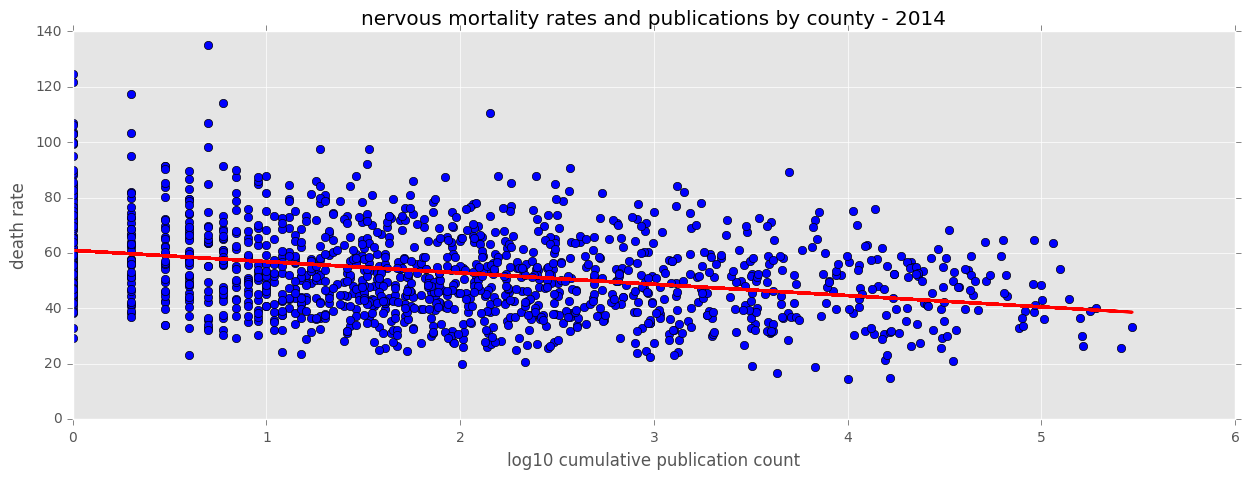

In [399]:
# include fips code with pubs_cols 
def plot_year(year, cause):
    """possible args:
    year = 1999-2014
    cause = ['all', 'circulatory', 'mental', 'neoplasms', 'nervous', 'respiratory']
    """
    plt_yr_pubs = mort_pubs.loc[(mort_pubs['year'] == year) & (mort_pubs['cause'] == cause), pubs_cols + ['fips']]
    plt_pub_sums = plt_yr_pubs.sum(axis=1, numeric_only=True)
    plt_pub_logs = np.log10(plt_pub_sums + 1)
    
    plt_yr_rate = mort_pubs.loc[(mort_pubs['year'] == year) & (mort_pubs['cause'] == cause),['rate']]
    #plt_yr_rate_logs = np.log10(plt_yr_rate)
    
    df = pd.DataFrame({'fips': plt_yr_pubs['fips'], 'pub_log_sum': plt_pub_logs, 'rate': plt_yr_rate['rate']})
    x = df.loc[:,'pub_log_sum']
    y = df.loc[:,'rate']
    fips = df.loc[:,'fips']
    
    f, ax1 = plt.subplots(1, figsize=(15,5))
    #plot df
    #ax1.scatter(x, y)
    ax1.plot(x, y, 'bo')
    ax1.set_xlabel('log10 cumulative publication count')
    ax1.set_ylabel('death rate')
    ax1.set_title('{0} mortality rates and publications by county - {1}'.format(cause, year))
    
    #plot ols regression line
    regr = linear_model.LinearRegression()
    regr.fit(x.to_frame(), y.to_frame())
    print(regr.coef_)
#     print(zip(feature_cols, lm.coef_))
    plt.plot(x.to_frame(), regr.predict(x.to_frame()), color='red', linewidth=2)
    plt.show()
    # return(df)


plot_year(2014,'nervous')

In [ ]:
for cause in mort_pubs.cause.unique():
    plot_year(1999, cause)

/Users/nataliedeclerck/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


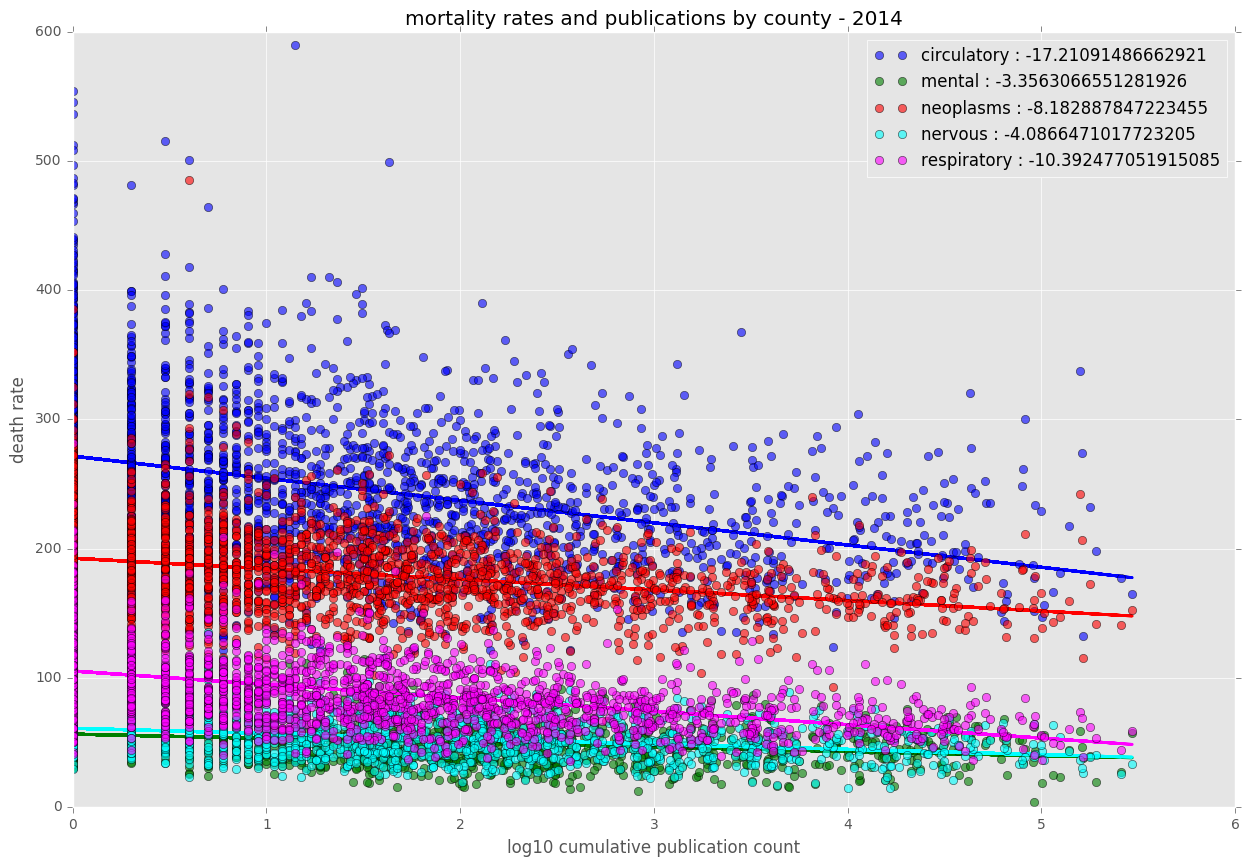

In [400]:
# change x to pubs_sum and bin and if there is curvature, apply x^2
# include fips code with pubs_cols 
def plot_year_causes(year):
    """possible args:
    year = 1999-2014
    to plot all causes, set causes = ['all', 'circulatory', 'mental', 'neoplasms', 'nervous', 'respiratory']
    """
    f, ax1 = plt.subplots(1, figsize=(15,10))
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    ax1.set_color_cycle(colors)
    causes = ['circulatory', 'mental', 'neoplasms', 'nervous', 'respiratory']
    for cause in causes:
        yr_pubs = mort_pubs.loc[(mort_pubs['year'] == year) & (mort_pubs['cause'] == cause), pubs_cols]
        #numeric_only=True so FIPS code is not added to sum
        pub_sums = yr_pubs.sum(axis=1, numeric_only=True)
        pub_logs = np.log10(pub_sums + 1)
        pubs_squared = pub_sums**2
        
        fips = mort_pubs.loc[(mort_pubs['year'] == year) & (mort_pubs['cause'] == cause),['fips']]
        yr_rate = mort_pubs.loc[(mort_pubs['year'] == year) & (mort_pubs['cause'] == cause),['rate']]
        #yr_rate_logs = np.log10(yr_rate)

        df = pd.DataFrame({'fips': fips['fips'], 
                           'pub_sums': pub_sums,
                           'pub_logs': pub_logs, 
                           'pubs_squared': pubs_squared, 
                           'rate': yr_rate['rate']})
        df = df.drop_duplicates()
        #display(df.head())
        x = df.loc[:,'pub_logs']
        y = df.loc[:,'rate']
        fips = df.loc[:,'fips']
        
        
        #plot regression lines
        idx = causes.index(cause)
        regr = linear_model.LinearRegression()
        regr.fit(x.to_frame(), y.to_frame())
        ax1.plot(x.to_frame(), regr.predict(x.to_frame()), linewidth=2, color=colors[idx])

        #plot points
        line, = ax1.plot(x, y, 'o', label=cause+' : {}'.format(regr.coef_[0][0]), alpha=0.6)
        
    ax1.legend()
        
    ax1.set_xlabel('log10 cumulative publication count')
    ax1.set_ylabel('death rate')
    ax1.set_title('mortality rates and publications by county - {0}'.format(year))
    
    plt.show()
    # return(df)


plot_year_causes(2014)

### binning? xlim?

- 1) circulatory
- 2) neoplasms
- 3) respiratory
- 4) nervous
- 5) mental

/Users/nataliedeclerck/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


circulatory [[ -1.48745201e-09]]
mental [[ -2.39494593e-10]]
neoplasms [[ -6.60937245e-10]]
nervous [[ -4.23923067e-10]]
respiratory [[ -9.44918634e-10]]


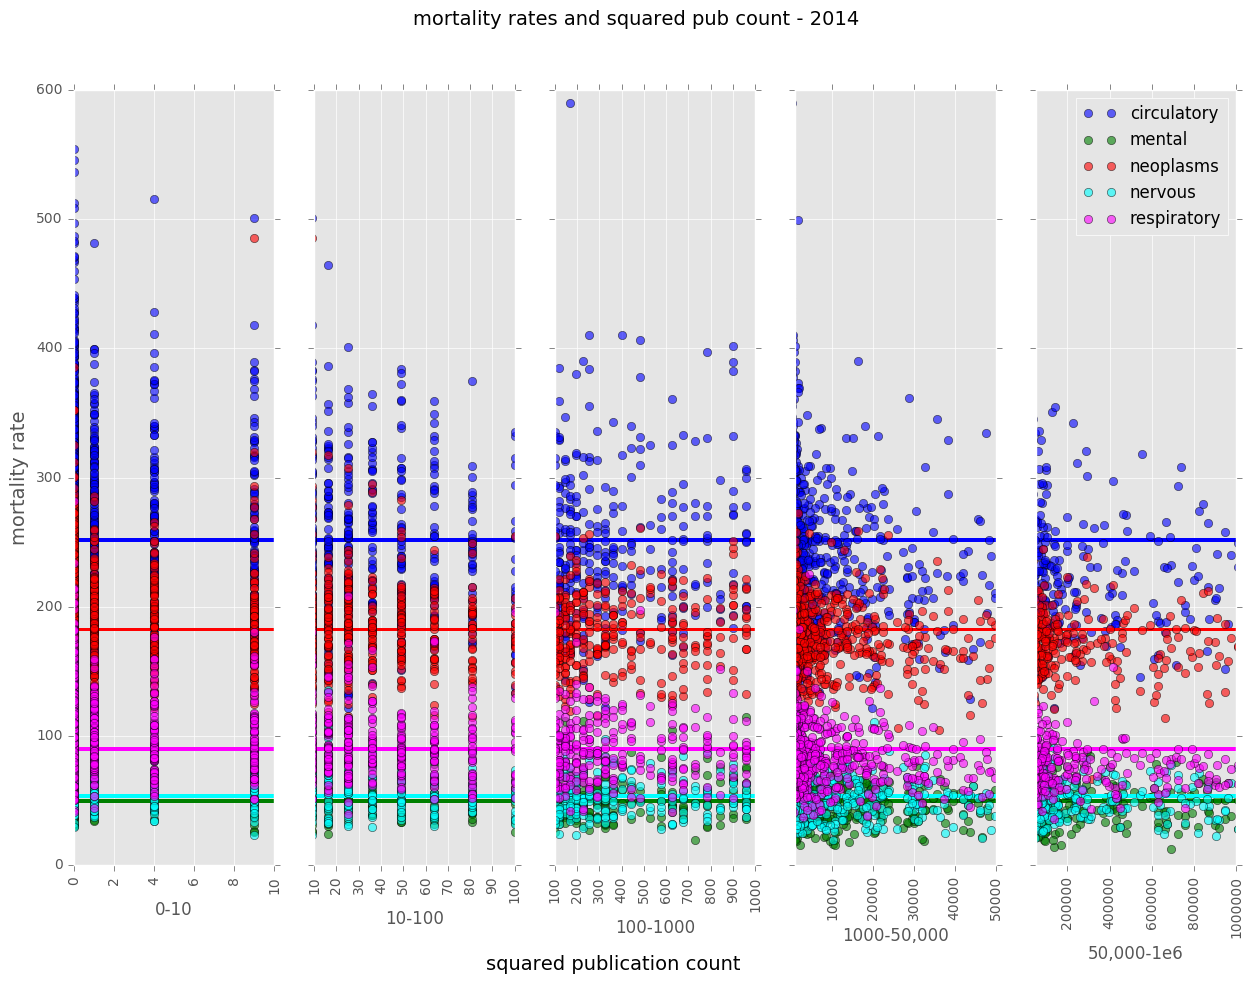

In [401]:
# include fips code with pubs_cols 
def plot_year_causes(year):
    """possible args:
    year = 1999-2014
    to plot all causes, set causes = ['all', 'circulatory', 'mental', 'neoplasms', 'nervous', 'respiratory']
    """
    f, axs = plt.subplots(1,5, sharey=True, figsize=(15,10))
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']
    axs[0].set_color_cycle(colors)
    axs[1].set_color_cycle(colors)
    axs[2].set_color_cycle(colors)
    axs[3].set_color_cycle(colors)
    axs[4].set_color_cycle(colors)
    causes = ['circulatory', 'mental', 'neoplasms', 'nervous', 'respiratory']
    for cause in causes:
        yr_pubs = mort_pubs.loc[(mort_pubs['year'] == year) & (mort_pubs['cause'] == cause), pubs_cols]
        #numeric_only=True so FIPS code is not added to sum
        pub_sums = yr_pubs.sum(axis=1, numeric_only=True)
        pub_logs = np.log10(pub_sums + 1)
        pubs_squared = pub_sums**2
        
        fips = mort_pubs.loc[(mort_pubs['year'] == year) & (mort_pubs['cause'] == cause),['fips']]
        yr_rate = mort_pubs.loc[(mort_pubs['year'] == year) & (mort_pubs['cause'] == cause),['rate']]
        #yr_rate_logs = np.log10(yr_rate)

        df = pd.DataFrame({'fips': fips['fips'], 
                           'pub_sums': pub_sums,
                           'pub_logs': pub_logs, 
                           'pubs_squared': pubs_squared, 
                           'rate': yr_rate['rate']})

        df = df.drop_duplicates()
        #display(df.head())
        
        x = df.loc[:,['pubs_squared']]
        y = df.loc[:,'rate']
        fips = df.loc[:,'fips']
        
        
        #plot regression lines
        idx = causes.index(cause)
        regr = linear_model.LinearRegression()
        regr.fit(x, y.to_frame())
        axs[0].plot(x, regr.predict(x), linewidth=2, color=colors[idx])
        axs[1].plot(x, regr.predict(x), linewidth=2, color=colors[idx])
        axs[2].plot(x, regr.predict(x), linewidth=2, color=colors[idx])
        axs[3].plot(x, regr.predict(x), linewidth=2, color=colors[idx])
        axs[4].plot(x, regr.predict(x), linewidth=2, color=colors[idx])
        print(cause, regr.coef_)
        
        
        #plot points
        points, = axs[0].plot(x, y, 'o', label=cause, alpha=0.6)
        axs[0].set_xlim((0,10), auto=True)
        
        points, = axs[1].plot(x, y, 'o', label=cause, alpha=0.6)
        axs[1].set_xlim((10,100), auto=True)
        
        points, = axs[2].plot(x, y, 'o', label=cause, alpha=0.6)
        axs[2].set_xlim((100,1000), auto=True)
        #axs[2].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        
        points, = axs[3].plot(x, y, 'o', label=cause, alpha=0.6)
        axs[3].set_xlim((1000,50000), auto=True)
        #axs[3].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        #ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        #axs[3].set_xticklabels([1000,2000,3000,4000,5000],rotation=90)
        
        points, = axs[4].plot(x, y, 'o', label=cause, alpha=0.6)
        axs[4].set_xlim((50000,1e6), auto=True)
        #axs[4].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    #rotate xlabels
    plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=90)
    plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=90)
    plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=90)
    plt.setp(axs[3].xaxis.get_majorticklabels(), rotation=90)
    plt.setp(axs[4].xaxis.get_majorticklabels(), rotation=90)
        
    axs[4].legend(loc='best',fontsize=12)
    
    axs[0].set_xlabel('0-10')
    axs[1].set_xlabel('10-100')
    axs[2].set_xlabel('100-1000')
    axs[3].set_xlabel('1000-50,000')
    axs[4].set_xlabel('50,000-1e6')
    
    axs[0].set_ylabel('mortality rate', fontsize=14)
    plt.suptitle('mortality rates and squared pub count - {0}'.format(year), fontsize=14, verticalalignment='top')

    
    #print(list(axs[3].xaxis.get_ticklabels()))
    #axs[3].set_xticklabels(axs[3].xaxis.get_ticklabels(),rotation=90)
    
    plt.figtext(.4, .02, 'squared publication count', fontsize=14)
    plt.show()
    # return(df)


plot_year_causes(2014)

### add log column to `count_PMID_by_year_fips`

In [403]:
#Don't run twice
count_PMID_by_year_fips['log_PMID'] = np.log10(count_PMID_by_year_fips['PMID_count'] + 1)

In [404]:
count_PMID_by_year_fips.head()

,fips,year,PMID_count,log_PMID
0,01001,1992,2,0.477121
1,01001,2016,1,0.301030
2,01003,1989,1,0.301030
3,01003,1990,1,0.301030
4,01003,1993,1,0.301030


In [405]:
df = count_PMID_by_year_fips[count_PMID_by_year_fips.fips == '30067']

regr = linear_model.LinearRegression()
regr.fit(df['year'].to_frame(), df['log_PMID'].to_frame())
print(regr.coef_)
# delta_pubs_dict[fips] = regr.coef_[0][0]

[[-0.00251559]]


,fips,year,PMID_count,log_PMID,square_PMID
18700,25017,1881,1,0.301030,1
18701,25017,1885,2,0.477121,4
18702,25017,1887,2,0.477121,4
18703,25017,1889,2,0.477121,4
18704,25017,1890,2,0.477121,4


[[ 0.02732263]]


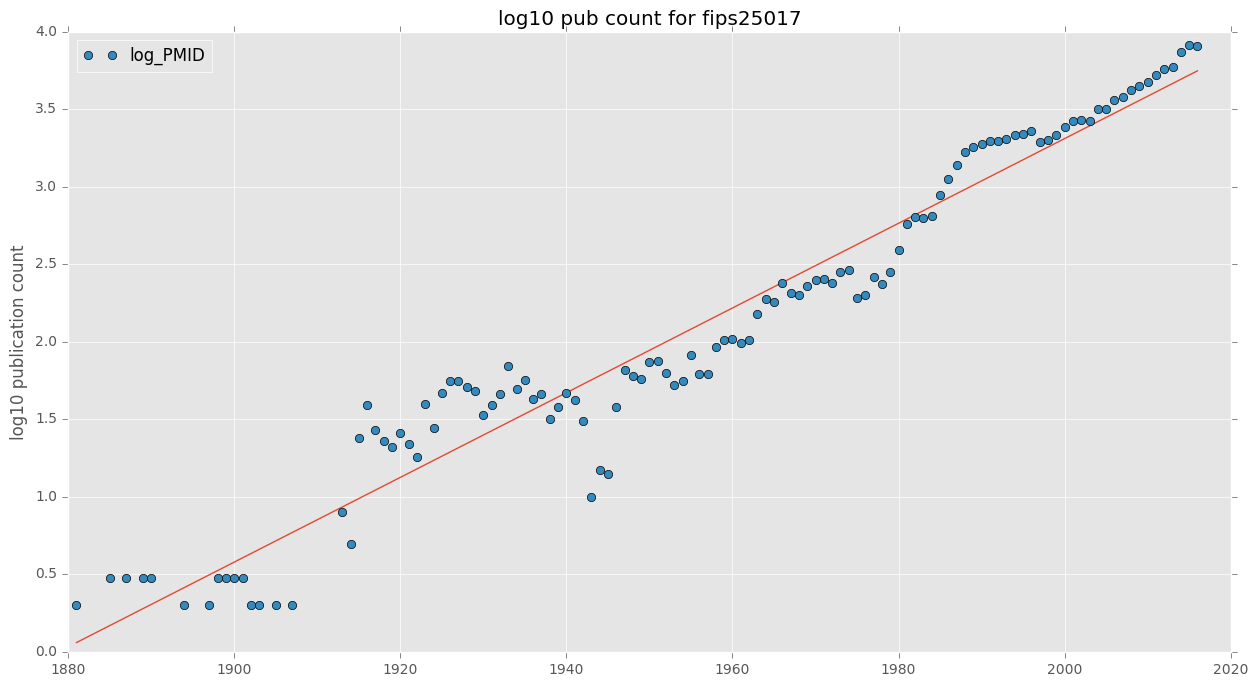

,fips,year,PMID_count,log_PMID,square_PMID
15174,21085,1989,1,0.301030,1
15175,21085,1990,2,0.477121,4
15176,21085,1991,3,0.602060,9


[[ 0.150515]]


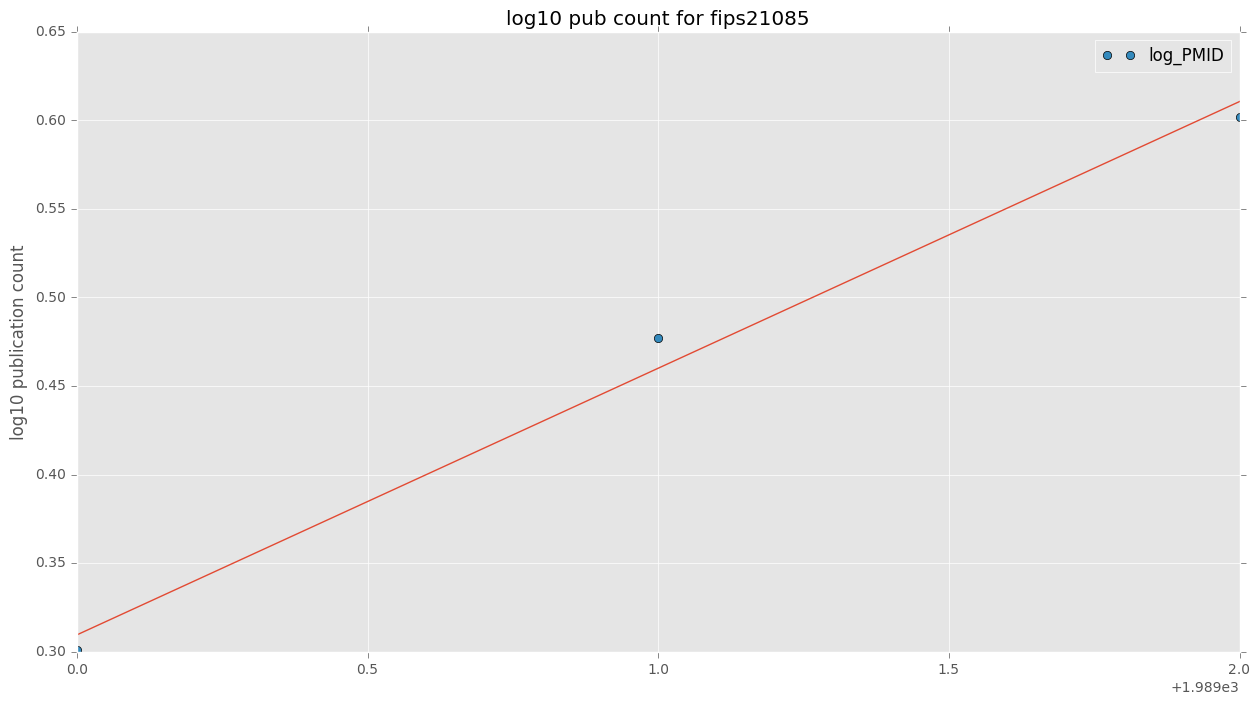

In [527]:
### change this to plot year x pubs for a fips using mort_pubs
def plot_year_pubs(fips):
    f, ax1 = plt.subplots(1, figsize=(15,8))

    df = count_PMID_by_year_fips.loc[(count_PMID_by_year_fips.fips == fips) & (count_PMID_by_year_fips.year < 2017), ['fips', 'year', 'PMID_count', 'log_PMID']]
    df = df.drop_duplicates()
    df['square_PMID'] = df['PMID_count']**2
    display(df.head())

    #yr_pubs = mort_pubs.loc[(mort_pubs['year'] == year) & (mort_pubs['cause'] == cause), pubs_cols]
    #numeric_only=True so FIPS code is not added to sum
    #pub_sums = yr_pubs.sum(axis=1, numeric_only=True)
    #pub_logs = np.log10(pub_sums + 1)
    #pubs_squared = pub_sums**2
    
    regr = linear_model.LinearRegression()
    regr.fit(df.year.to_frame(), df.log_PMID.to_frame())
    print(regr.coef_)
    ax1.plot(df.year.to_frame(), regr.predict(df.year.to_frame()), linewidth=1)

    ax1.plot(df['year'], df['log_PMID'], 'o')

    ax1.set_title('log10 pub count for fips'+fips)
    ax1.set_ylabel('log10 publication count')
    ax1.legend(loc='best')
    plt.show()

#no change   
#plot_year_pubs('51177')

#plot_year_pubs('01001')

# plot_year_pubs('17019') #CU
plot_year_pubs('25017') #Boston
# plot_year_pubs('17031') #Chicago
# plot_year_pubs('06087') #LA

# outliers where delta_pubs > 0.08
plot_year_pubs('21085') # Leitchfield, KY
# plot_year_pubs('26141') # Millersburg, MI
# plot_year_pubs('01071') # Princeton, AL


#### Use `count_PMID_by_year` to create dictionary & df of fips and change rate over 1988-2016
- 2017 data is incomplete, so don't use those values when calculating regression coefficient

In [412]:
count_PMID_by_year_fips.head()

,fips,year,PMID_count,log_PMID
0,01001,1992,2,0.477121
1,01001,2016,1,0.301030
2,01003,1989,1,0.301030
3,01003,1990,1,0.301030
4,01003,1993,1,0.301030


In [417]:
#create dictionary of fips and pub change rate
delta_pubs_dict = {}
for fips in count_PMID_by_year_fips.fips.unique():
    #2017 data is incomplete, so remove those when calculating regression coefficient
    df = count_PMID_by_year_fips.loc[(count_PMID_by_year_fips.fips == fips) & (count_PMID_by_year_fips.year < 2017), ['fips', 'year', 'log_PMID']]
    df = df.drop_duplicates()
    #df['log_PMID'] = np.log10(df['PMID'] + 1)
    #display(df.head())

    regr = linear_model.LinearRegression()
    regr.fit(df['year'].to_frame(), df['log_PMID'].to_frame())
    #print(regr.coef_)
    delta_pubs_dict[fips] = regr.coef_[0][0]

In [423]:
delta_pubs_dict['21085']

0.15051499783199057

#### change dictionary to df for merge with `mort_pubs`

In [425]:
delta_pubs = pd.DataFrame.from_dict(delta_pubs_dict, orient='index').reset_index()
delta_pubs.columns = ['fips', 'delta_pub']

delta_pubs.head()


,fips,delta_pub
0,51173,0.000000
1,05043,0.004895
2,18169,0.003515
3,50015,0.004078
4,37083,0.005717


#### Use death rate coefficients to create a df with `cause`, `fips`, and a `delta_rate` (change in death rate calculated from 1999-2014)

/Users/nataliedeclerck/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


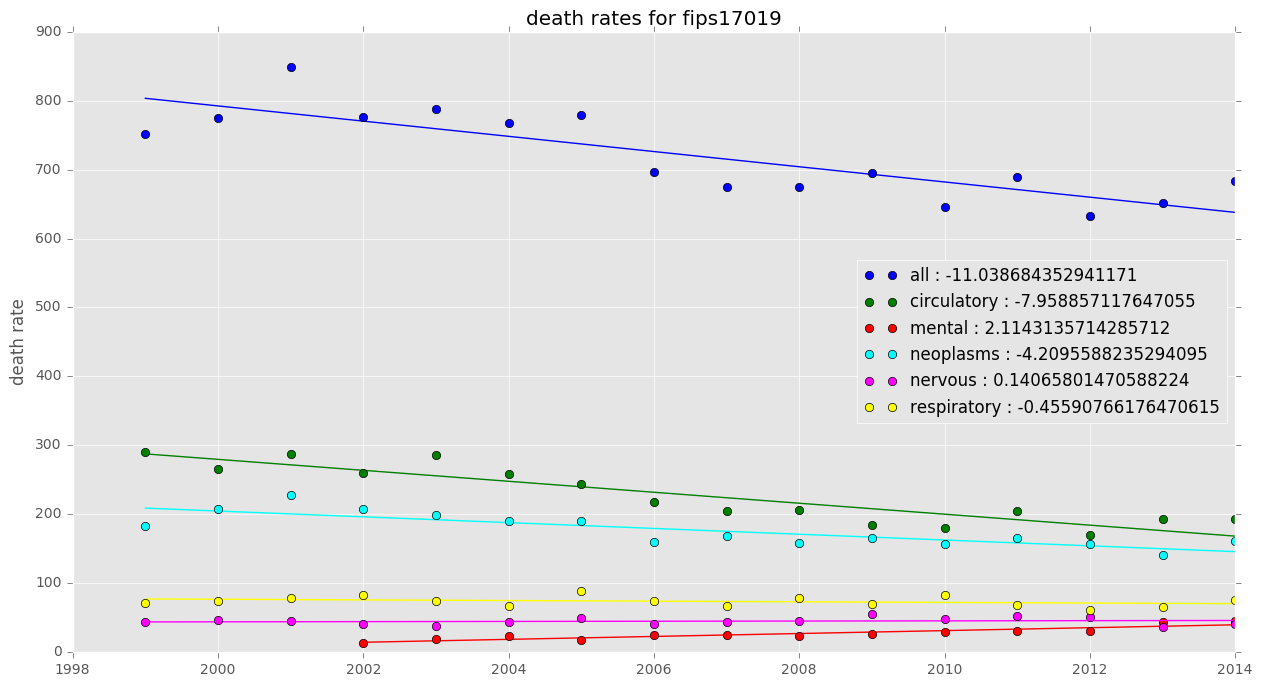

In [426]:
def plot_year_rate(fips):
    f, ax1 = plt.subplots(1, figsize=(15,8))
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    ax1.set_color_cycle(colors)
    causes = ['all','circulatory', 'mental', 'neoplasms', 'nervous', 'respiratory']
    for cause in causes:
        df = mort_pubs.loc[(mort_pubs.cause == cause) & (mort_pubs.fips == fips), ['fips', 'cause', 'year', 'rate']]

        idx = causes.index(cause)
        
        regr = linear_model.LinearRegression()
        regr.fit(df.year.to_frame(), df.rate.to_frame())
        #print(regr.coef_)
        ax1.plot(df.year.to_frame(), regr.predict(df.year.to_frame()), color=colors[idx], linewidth=1)
        
        line, = ax1.plot(df['year'], df['rate'], 'o', label=cause+' : {}'.format(regr.coef_[0][0]))
        
    ax1.set_title('death rates for fips'+fips)
    ax1.set_ylabel('death rate')
    ax1.legend(loc='best')
    plt.show()

plot_year_rate('17019')

In [435]:
mort_pubs.loc[(mort_pubs.fips == '21085') & (mort_pubs.cause == 'mental'),:]

         fips        cause  delta_rate
0       01001          all  -10.863475
16      01001  circulatory   -8.852085
32      01001       mental  -11.246070
34      01001    neoplasms   -3.415147
50      01001      nervous   -1.924066
56      01001  respiratory    1.515124
72      01003          all         NaN
88      01003  circulatory         NaN
104     01003       mental         NaN
120     01003    neoplasms         NaN
136     01003      nervous         NaN
152     01003  respiratory         NaN
168     01005          all         NaN
184     01005  circulatory         NaN
200     01005    neoplasms         NaN
216     01005      nervous         NaN
222     01005  respiratory         NaN
234     01007          all         NaN
250     01007  circulatory         NaN
266     01007    neoplasms         NaN
282     01007  respiratory         NaN
294     01009          all         NaN
310     01009  circulatory         NaN
326     01009       mental         NaN
332     01009    neoplasm

In [462]:
delta_rate = mort_pubs.loc[(mort_pubs.fips == '21085'),['fips', 'cause']].drop_duplicates()
delta_rate

,fips,cause
64141,21085,all
64157,21085,circulatory
64173,21085,neoplasms
64189,21085,nervous
64191,21085,respiratory


In [472]:
# #plot_year_pubs('51177')

# # plot_year_pubs('17019') #CU
# plot_year_pubs('25017') #Boston
# # plot_year_pubs('17031') #Chicago
# # plot_year_pubs('06087') #LA

# # outliers where delta_pubs > 0.08
# plot_year_pubs('21085') # Leitchfield, KY
# # plot_year_pubs('26141') # Millersburg, MI
# # plot_year_pubs('01071') # Princeton, AL


delta = mort_pubs.loc[:,['fips', 'cause']].drop_duplicates()
#delta_rate = pd.DataFrame(columns = ['cause', 'fips'])
for fips in ['01001', '25017', '17019', '17031', '21085', '51177']:
#for fips in ['21085']:
    for cause in mort_pubs.cause.unique():
        df = mort_pubs.loc[(mort_pubs.cause == cause) & (mort_pubs.fips == fips), ['year', 'rate']].drop_duplicates()
        display(df.head())
        if len(df) > 0:
            #display(df.head())
            regr = linear_model.LinearRegression()
            regr.fit(df.year.to_frame(), df.rate.to_frame())
            #print(regr.coef_)
            delta.loc[(delta.cause == cause) & (delta.fips == fips),'delta_rate'] = regr.coef_[0][0]
        else:
            #print(fips, cause)

,year,rate
0,1999,1064.73351
1,2000,1021.78792
2,2001,1008.79702
3,2002,1037.62083
4,2003,1038.44489


,year,rate
16,1999,416.27091
17,2000,433.90861
18,2001,430.72231
19,2002,378.62585
20,2003,399.39245


,year,rate
32,2010,57.35239
33,2011,46.10632


,year,rate
34,1999,264.5
35,2000,224.9
36,2001,178.2
37,2002,238.8
38,2003,171.0


,year,rate
50,2003,70.70183
51,2004,68.36369
52,2005,68.19907
53,2011,53.48213
54,2013,45.77361


,year,rate
56,1999,80.09244
57,2000,62.28740
58,2001,64.24400
59,2002,100.05730
60,2003,116.15444


,year,rate
77332,1999,765.51380
77333,2000,781.91628
77334,2001,762.36699
77335,2002,759.22086
77336,2003,721.28241


,year,rate
77348,1999,278.53943
77349,2000,275.14537
77350,2001,261.42573
77351,2002,260.58642
77352,2003,244.46390


,year,rate
77364,1999,20.97448
77365,2000,23.04539
77366,2001,28.09641
77367,2002,33.34110
77368,2003,31.81712


,year,rate
77380,1999,209.2
77381,2000,206.8
77382,2001,204.2
77383,2002,200.3
77384,2003,186.9


,year,rate
77396,1999,32.90058
77397,2000,34.12312
77398,2001,39.57622
77399,2002,36.27967
77400,2003,34.49866


,year,rate
77412,1999,80.43749
77413,2000,92.69870
77414,2001,78.56814
77415,2002,79.53588
77416,2003,77.10894


,year,rate
38068,1999,752.02095
38069,2000,775.12810
38070,2001,848.95169
38071,2002,777.16701
38072,2003,788.56846


,year,rate
38084,1999,289.83920
38085,2000,265.73027
38086,2001,287.53638
38087,2002,259.20879
38088,2003,285.31676


,year,rate
38100,2002,12.96565
38101,2003,19.08889
38102,2004,23.46429
38103,2005,16.87611
38104,2006,24.14345


,year,rate
38113,1999,182.2
38114,2000,207.4
38115,2001,228.1
38116,2002,207.5
38117,2003,198.5


,year,rate
38129,1999,43.91956
38130,2000,46.02099
38131,2001,44.65371
38132,2002,40.08084
38133,2003,37.80478


,year,rate
38145,1999,70.92928
38146,2000,73.25875
38147,2001,78.49082
38148,2002,82.10971
38149,2003,74.31692


,year,rate
38491,1999,953.24781
38492,2000,917.01632
38493,2001,900.52249
38494,2002,890.76865
38495,2003,864.32939


,year,rate
38507,1999,383.96078
38508,2000,359.74021
38509,2001,350.55486
38510,2002,341.45501
38511,2003,326.99029


,year,rate
38523,1999,13.87581
38524,2000,15.57212
38525,2001,16.91141
38526,2002,19.06308
38527,2003,18.05935


,year,rate
38539,1999,222.5
38540,2000,221.3
38541,2001,215.5
38542,2002,212.2
38543,2003,207.5


,year,rate
38555,1999,28.15634
38556,2000,30.40185
38557,2001,30.55285
38558,2002,30.97877
38559,2003,32.39680


,year,rate
38571,1999,83.96931
38572,2000,75.16085
38573,2001,74.12724
38574,2002,73.62957
38575,2003,71.05433


,year,rate
64141,1999,1014.77520
64142,2000,1114.44513
64143,2001,1269.78678
64144,2002,1052.83519
64145,2003,1092.20478


,year,rate
64157,1999,428.24797
64158,2000,454.83005
64159,2001,447.15363
64160,2002,420.82598
64161,2003,398.23043


,year,rate


21085 mental


,year,rate
64173,1999,231.7
64174,2000,233.0
64175,2001,236.0
64176,2002,214.5
64177,2003,178.8


,year,rate
64189,2010,78.79410
64190,2014,81.67709


,year,rate
64191,1999,142.02298
64192,2000,158.12720
64193,2001,191.60340
64194,2002,126.66065
64195,2003,177.75184


,year,rate
181346,1999,883.52749
181347,2000,833.99416
181348,2001,787.67214
181349,2002,914.94666
181350,2003,889.69179


,year,rate
181362,1999,293.26243
181363,2000,291.39515
181364,2001,280.73475
181365,2002,304.55690
181366,2003,280.12154


,year,rate
181378,2004,38.54910
181379,2006,26.94065
181380,2007,24.20204
181381,2008,40.23877
181382,2009,48.02583


,year,rate
181388,1999,231.8
181389,2000,251.9
181390,2001,183.8
181391,2002,236.6
181392,2003,217.9


,year,rate
181404,2001,41.05611
181405,2002,52.46480
181406,2003,60.79228
181407,2004,44.57150
181408,2005,58.95991


,year,rate
181418,1999,87.76195
181419,2000,77.60272
181420,2001,100.38238
181421,2002,102.59313
181422,2003,123.18149


In [476]:
delta_rate.loc[pd.isnull(delta.delta_rate) == False,:]
# delta

,fips,cause,delta_rate
0,01001,all,-10.863475
16,01001,circulatory,-8.852085
32,01001,mental,-11.246070
34,01001,neoplasms,-3.415147
50,01001,nervous,-1.924066
56,01001,respiratory,1.515124
38068,17019,all,-11.038684
38084,17019,circulatory,-7.958857
38100,17019,mental,2.114314
38113,17019,neoplasms,-4.209559


In [477]:
#THIS TAKES FOREVER
delta_rate = mort_pubs.loc[:,['fips', 'cause']].drop_duplicates()
for fips in mort_pubs.fips.unique():
    for cause in mort_pubs.cause.unique():
        df = mort_pubs.loc[(mort_pubs.cause == cause) & (mort_pubs.fips == fips), ['year', 'rate']].drop_duplicates()
        if len(df) > 0:
            #display(df.head())
            regr = linear_model.LinearRegression()
            regr.fit(df.year.to_frame(), df.rate.to_frame())
            #print(regr.coef_)
            delta_rate.loc[(delta_rate.cause == cause) & (delta_rate.fips == fips),'delta_rate'] = regr.coef_[0][0]

In [478]:
delta_rate.head()

,fips,cause,delta_rate
0,01001,all,-10.863475
16,01001,circulatory,-8.852085
32,01001,mental,-11.246070
34,01001,neoplasms,-3.415147
50,01001,nervous,-1.924066


In [500]:
mapAffil.loc[(mapAffil['fips'] == '01005')]

,PMID,au_order,year,type,city,state,country,lat,lon,fips


In [503]:
mort_pubs.loc[(pd.isnull(mort_pubs['delta_pub']) == True), :]
# mort_pubs.head()

,fips,cause,year,rate,pubs_1988,pubs_1989,pubs_1990,pubs_1991,pubs_1992,pubs_1993,pubs_1994,pubs_1995,pubs_1996,pubs_1997,pubs_1998,pubs_1999,pubs_2000,pubs_2001,pubs_2002,pubs_2003,pubs_2004,pubs_2005,pubs_2006,pubs_2007,pubs_2008,pubs_2009,pubs_2010,pubs_2011,pubs_2012,pubs_2013,pubs_2014,pubs_2015,pubs_2016,pubs_2017,delta_pub


#### Merge change in death rate (1999-2014) and change in pub count (1988-2016) into `mort_pubs`
- each `fips` & `cause` has a unique `delta_rate`
- each `fips` has a unique `delta_pub`

In [504]:
#mort_pubs = pd.merge(mort_pubs, delta_pubs, how='inner', on='fips')
mort_pubs = pd.merge(mort_pubs, delta_rate, how='left', on=['fips', 'cause'])

#### Remove rows where FIPS is in mortality data but not in mapAffil

In [505]:
#print(mort_pubs.shape)
#print(mort_pubs.drop_duplicates().shape)

#These are the rows where fps is in mortality data but not in mapAffil
print(len(mort_pubs.loc[(pd.isnull(mort_pubs['delta_pub']) == True), :]))
print(len(mort_pubs.loc[(pd.isnull(mort_pubs['delta_rate']) == True), :]))
# mort_pubs = mort_pubs.loc[(pd.isnull(mort_pubs['city']) == False), :]

0
0


In [506]:
mort_pubs.head()

,fips,cause,year,rate,pubs_1988,pubs_1989,pubs_1990,pubs_1991,pubs_1992,pubs_1993,pubs_1994,pubs_1995,pubs_1996,pubs_1997,pubs_1998,pubs_1999,pubs_2000,pubs_2001,pubs_2002,pubs_2003,pubs_2004,pubs_2005,pubs_2006,pubs_2007,pubs_2008,pubs_2009,pubs_2010,pubs_2011,pubs_2012,pubs_2013,pubs_2014,pubs_2015,pubs_2016,pubs_2017,delta_pub,delta_rate
0,01001,all,1999,1064.73351,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.007337,-10.863475
1,01001,all,2000,1021.78792,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.007337,-10.863475
2,01001,all,2001,1008.79702,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.007337,-10.863475
3,01001,all,2002,1037.62083,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.007337,-10.863475
4,01001,all,2003,1038.44489,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.007337,-10.863475


In [510]:
# #reorder cols - dont do this twice
# cols = mort_pubs.columns.tolist()
# cols = cols[:4]+cols[-2:]+pubs_cols
# print(cols)
# mort_pubs = mort_pubs[cols]
# mort_pubs.head()

['fips', 'cause', 'year', 'rate', 'delta_pub', 'delta_rate', 'pubs_1988', 'pubs_1989', 'pubs_1990', 'pubs_1991', 'pubs_1992', 'pubs_1993', 'pubs_1994', 'pubs_1995', 'pubs_1996', 'pubs_1997', 'pubs_1998', 'pubs_1999', 'pubs_2000', 'pubs_2001', 'pubs_2002', 'pubs_2003', 'pubs_2004', 'pubs_2005', 'pubs_2006', 'pubs_2007', 'pubs_2008', 'pubs_2009', 'pubs_2010', 'pubs_2011', 'pubs_2012', 'pubs_2013', 'pubs_2014', 'pubs_2015', 'pubs_2016', 'pubs_2017']


,fips,cause,year,rate,delta_pub,delta_rate,pubs_1988,pubs_1989,pubs_1990,pubs_1991,pubs_1992,pubs_1993,pubs_1994,pubs_1995,pubs_1996,pubs_1997,pubs_1998,pubs_1999,pubs_2000,pubs_2001,pubs_2002,pubs_2003,pubs_2004,pubs_2005,pubs_2006,pubs_2007,pubs_2008,pubs_2009,pubs_2010,pubs_2011,pubs_2012,pubs_2013,pubs_2014,pubs_2015,pubs_2016,pubs_2017
0,01001,all,1999,1064.73351,-0.007337,-10.863475,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,01001,all,2000,1021.78792,-0.007337,-10.863475,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,01001,all,2001,1008.79702,-0.007337,-10.863475,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,01001,all,2002,1037.62083,-0.007337,-10.863475,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,01001,all,2003,1038.44489,-0.007337,-10.863475,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Export `mort_pubs` to CSV

In [511]:
mort_pubs.to_csv('./data/mort_pubs.tsv', sep='\t')

#### Boston

In [512]:
# with pd.option_context("display.max_rows",500,"display.max_columns", 40):
#     display(mort_pubs.loc[(mort_pubs.city.str.contains('Boston')), ['fips', 'city', 'delta_pub'] + pubs_cols].drop_duplicates())

In [517]:
mort_pubs.loc[mort_pubs.delta_pub == mort_pubs.delta_pub.max(),['fips', 'delta_pub'] + pubs_cols].drop_duplicates()

,fips,delta_pub,pubs_1988,pubs_1989,pubs_1990,pubs_1991,pubs_1992,pubs_1993,pubs_1994,pubs_1995,pubs_1996,pubs_1997,pubs_1998,pubs_1999,pubs_2000,pubs_2001,pubs_2002,pubs_2003,pubs_2004,pubs_2005,pubs_2006,pubs_2007,pubs_2008,pubs_2009,pubs_2010,pubs_2011,pubs_2012,pubs_2013,pubs_2014,pubs_2015,pubs_2016,pubs_2017
46443,21085,0.150515,0.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/Users/nataliedeclerck/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


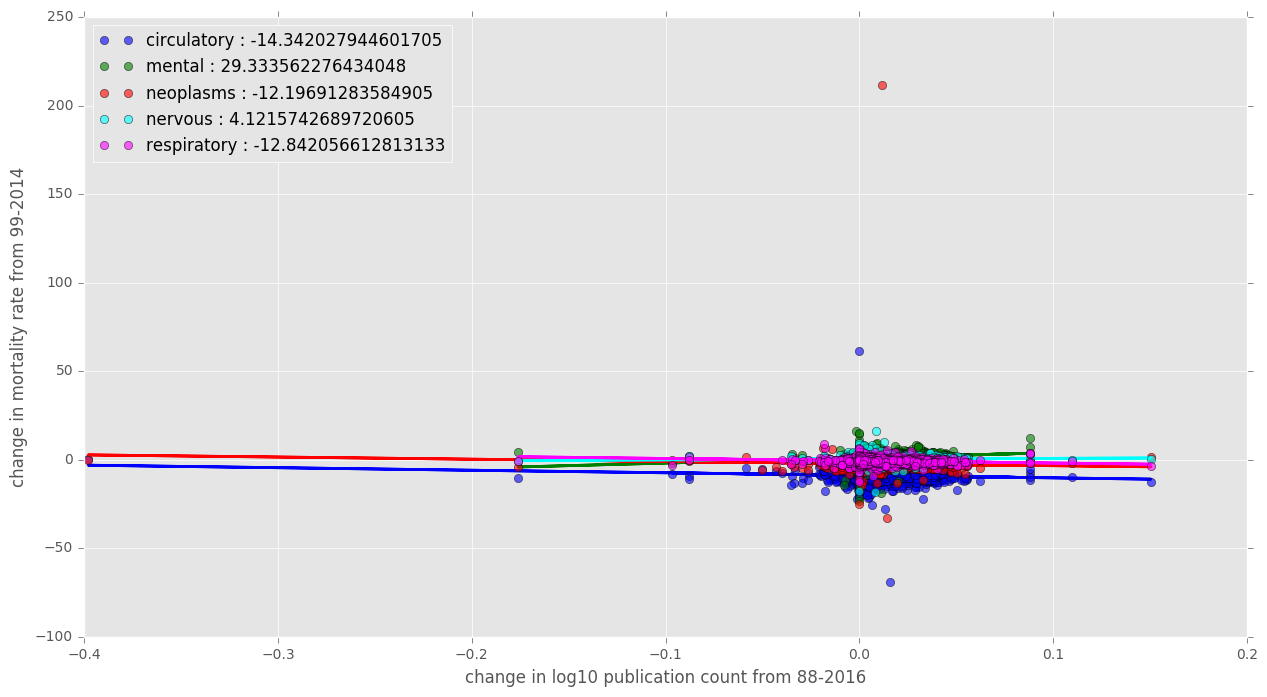

In [518]:
#bin this so it's easier to see
def plot_rateofchange():
    
    f, ax1 = plt.subplots(1, figsize=(15,8))
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    ax1.set_color_cycle(colors)
    causes = ['circulatory', 'mental', 'neoplasms', 'nervous', 'respiratory']
    for cause in causes:
        # all points
        df = mort_pubs.loc[(mort_pubs.cause == cause),['fips', 'delta_rate', 'delta_pub']].drop_duplicates()
        # without outliers
#         df = mort_pubs.loc[(mort_pubs.cause == cause)
#                            & (mort_pubs.delta_rate < 50)
#                            & (mort_pubs.delta_rate > -50),
#                            ['fips', 'delta_rate', 'delta_pub']].drop_duplicates()
        
        x = df.loc[:,'delta_pub']
        y = df.loc[:,'delta_rate']
        #logx = np.log10(df.delta_pub + 1)
        #logy = np.log10(df.delta_pub + 1)

        regr = linear_model.LinearRegression()
        regr.fit(x.to_frame(), y.to_frame())
        ax1.plot(x.to_frame(), regr.predict(x.to_frame()), linewidth=2)
        
        idx = causes.index(cause)
        
        points, = ax1.plot(x, y, 'o', label=cause+' : {}'.format(regr.coef_[0][0]), color=colors[idx], alpha=0.6)
    
    ax1.legend(loc='best')
    ax1.set_ylabel('change in mortality rate from 99-2014')
    ax1.set_xlabel('change in log10 publication count from 88-2016')
    plt.show()

plot_rateofchange()


/Users/nataliedeclerck/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


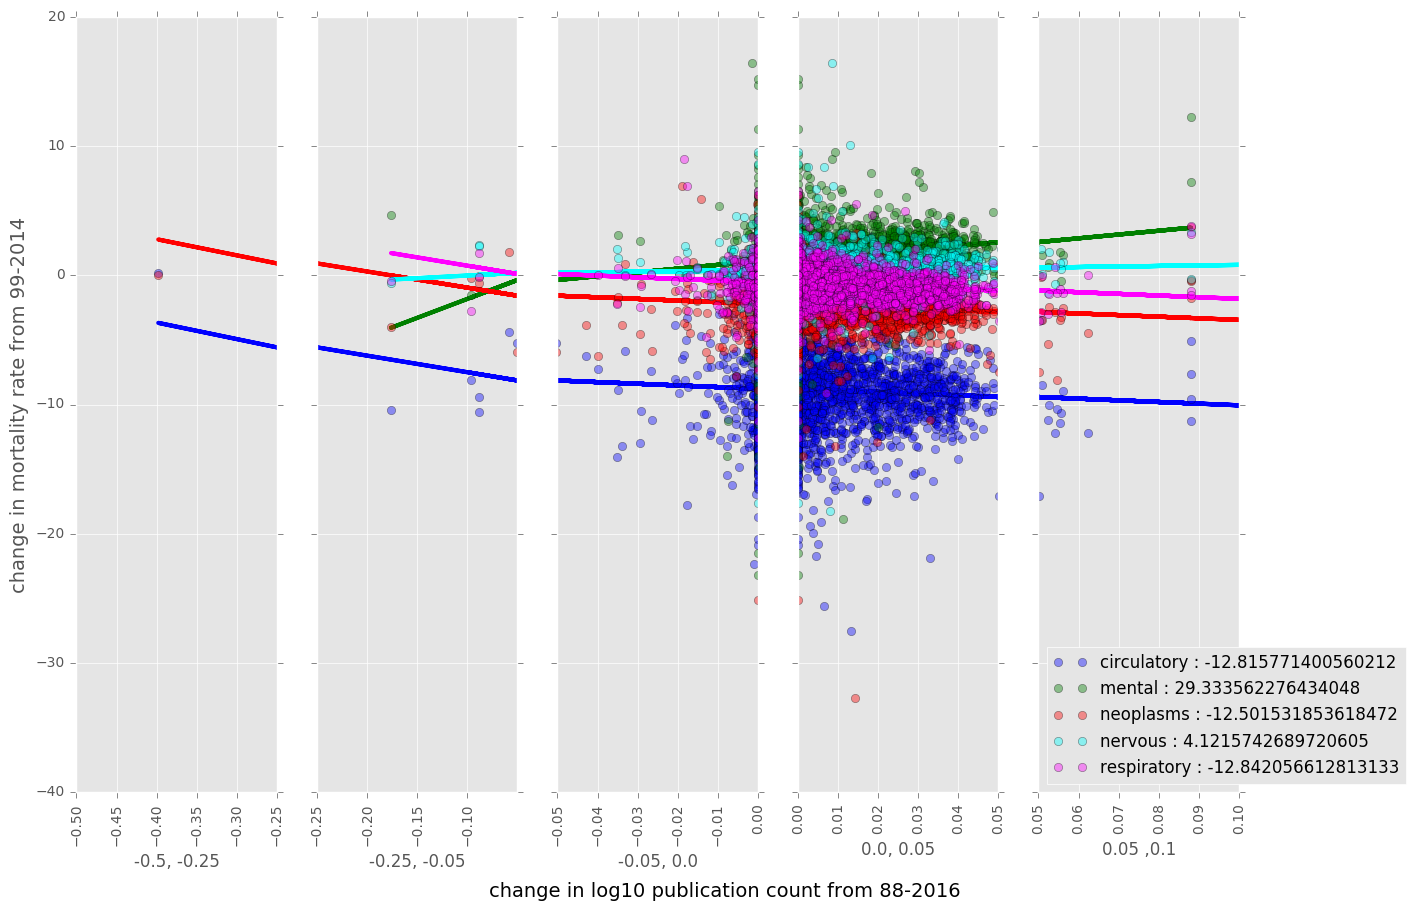

In [519]:
#bin this so it's easier to see
def plot_rateofchange():
    
    f, axs = plt.subplots(1,5, sharey=True, figsize=(15,10))
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    axs[0].set_color_cycle(colors)
    axs[1].set_color_cycle(colors)
    axs[2].set_color_cycle(colors)
    axs[3].set_color_cycle(colors)
    axs[4].set_color_cycle(colors)
    causes = ['circulatory', 'mental', 'neoplasms', 'nervous', 'respiratory']
    #causes = ['circulatory', 'respiratory']
    for cause in causes:
        # all points
        # df = mort_pubs.loc[(mort_pubs.cause == cause),['fips', 'delta_rate', 'delta_pub']].drop_duplicates()
        # without outliers
        df = mort_pubs.loc[(mort_pubs.cause == cause)
                           & (mort_pubs.delta_rate < 50)
                           & (mort_pubs.delta_rate > -50),
                           ['fips', 'delta_rate', 'delta_pub']].drop_duplicates()
        
        x = df.loc[:,'delta_pub']
        y = df.loc[:,'delta_rate']
        #logx = np.log10(df.delta_pub + 1)
        #logy = np.log10(df.delta_pub + 1)
        
        idx = causes.index(cause)
        regr = linear_model.LinearRegression()
        regr.fit(x.to_frame(), y.to_frame())

        axs[0].plot(x.to_frame(), regr.predict(x.to_frame()), linewidth=3, color=colors[idx], alpha=1)
        axs[1].plot(x.to_frame(), regr.predict(x.to_frame()), linewidth=3, color=colors[idx], alpha=1)
        axs[2].plot(x.to_frame(), regr.predict(x.to_frame()), linewidth=3, color=colors[idx], alpha=1)
        axs[3].plot(x.to_frame(), regr.predict(x.to_frame()), linewidth=3, color=colors[idx], alpha=1)
        axs[4].plot(x.to_frame(), regr.predict(x.to_frame()), linewidth=3, color=colors[idx], alpha=1)
        
        
        points, = axs[0].plot(x, y, 'o', label=cause+' : {}'.format(regr.coef_[0][0]), alpha=0.4, color=colors[idx])
        axs[0].set_xlim((-0.5,-0.25), auto=True)
        points, = axs[1].plot(x, y, 'o', label=cause+' : {}'.format(regr.coef_[0][0]), alpha=0.4, color=colors[idx])
        axs[1].set_xlim((-0.25,-0.05), auto=True)
        points, = axs[2].plot(x, y, 'o', label=cause+' : {}'.format(regr.coef_[0][0]), alpha=0.4, color=colors[idx])
        axs[2].set_xlim((-0.05,0), auto=True)
        points, = axs[3].plot(x, y, 'o', label=cause+' : {}'.format(regr.coef_[0][0]), alpha=0.4, color=colors[idx])
        axs[3].set_xlim((0,0.05), auto=True)
        points, = axs[4].plot(x, y, 'o', label=cause+' : {}'.format(regr.coef_[0][0]), alpha=0.4, color=colors[idx])
        axs[4].set_xlim((0.05,0.1), auto=True)
        
        
        #line, = ax1.plot(x, y, 'o', label=cause+' : {}'.format(regr.coef_[0][0]), color=colors[idx], alpha=0.6)
    
    plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=90)
    plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=90)
    plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=90)
    plt.setp(axs[3].xaxis.get_majorticklabels(), rotation=90)
    plt.setp(axs[4].xaxis.get_majorticklabels(), rotation=90)
    
    axs[0].set_xlabel('-0.5, -0.25')
    axs[1].set_xlabel('-0.25, -0.05')
    axs[2].set_xlabel('-0.05, 0.0')
    axs[3].set_xlabel('0.0, 0.05')
    axs[4].set_xlabel('0.05 ,0.1')
    
    axs[4].legend(loc='best',fontsize=12)
    axs[0].set_ylabel('change in mortality rate from 99-2014', fontsize=14)
    plt.figtext(.4, .02, 'change in log10 publication count from 88-2016', fontsize=14)
    plt.savefig('./delta_graph')
    plt.show()
    

plot_rateofchange()


In [535]:
mort_pubs.head(25)

,fips,cause,year,rate,delta_pub,delta_rate,pubs_1988,pubs_1989,pubs_1990,pubs_1991,pubs_1992,pubs_1993,pubs_1994,pubs_1995,pubs_1996,pubs_1997,pubs_1998,pubs_1999,pubs_2000,pubs_2001,pubs_2002,pubs_2003,pubs_2004,pubs_2005,pubs_2006,pubs_2007,pubs_2008,pubs_2009,pubs_2010,pubs_2011,pubs_2012,pubs_2013,pubs_2014,pubs_2015,pubs_2016,pubs_2017
0,01001,all,1999,1064.73351,-0.007337,-10.863475,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,01001,all,2000,1021.78792,-0.007337,-10.863475,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,01001,all,2001,1008.79702,-0.007337,-10.863475,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,01001,all,2002,1037.62083,-0.007337,-10.863475,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,01001,all,2003,1038.44489,-0.007337,-10.863475,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,01001,all,2004,934.52341,-0.007337,-10.863475,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,01001,all,2005,1123.39499,-0.007337,-10.863475,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,01001,all,2006,1073.07450,-0.007337,-10.863475,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,01001,all,2007,906.71136,-0.007337,-10.863475,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,01001,all,2008,975.42381,-0.007337,-10.863475,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Look at outliers:

### most positive change in publication count

In [529]:
mort_pubs.loc[(mort_pubs.delta_pub > 0.08),['fips', 'delta_pub', 'cause', 'delta_rate']].drop_duplicates().sort_values(by='delta_pub', axis=0)
#01071:Princeton, AL, USA
#13103:Guyton, GA, USA
#20205:Fredonia, KS, USA; Neodesha, KS, USA
#21085:Leitchfield, KY, USA
#21231:Monticello, KY, USA
#26141:Millersburg, MI, USA

,fips,delta_pub,cause,delta_rate
1428,01071,0.088046,all,2.114127
48947,21231,0.088046,respiratory,-1.533037
48931,21231,0.088046,neoplasms,-1.750441
48915,21231,0.088046,circulatory,-9.590938
48899,21231,0.088046,all,-10.024418
44937,20205,0.088046,respiratory,3.830567
44906,20205,0.088046,circulatory,-5.048242
44890,20205,0.088046,all,-0.499815
22319,13103,0.088046,respiratory,-1.210143
22317,13103,0.088046,nervous,3.328750


### most negative change in publication count

In [530]:
mort_pubs.loc[(mort_pubs.delta_pub < -0.15),['fips', 'delta_pub','cause', 'delta_rate']].drop_duplicates().sort_values(by='delta_pub', axis=0)
#30015: Fort Benton, MT, USA
#48481:Wharton, TX, USA	

,fips,delta_pub,cause,delta_rate
73751,30015,-0.397940,all,1.531468
73767,30015,-0.397940,circulatory,0.203034
73774,30015,-0.397940,neoplasms,0.000000
128981,48481,-0.176091,all,-9.083048
128997,48481,-0.176091,circulatory,-10.430350
129013,48481,-0.176091,mental,4.676801
129018,48481,-0.176091,neoplasms,-3.993676
129034,48481,-0.176091,nervous,-0.591448
129036,48481,-0.176091,respiratory,-0.466676


### most positive change in death rate

In [531]:
mort_pubs.loc[(mort_pubs.delta_rate > 50),:].sort_values(by='delta_rate', axis=0)
#29129: Princeton, MO, USA
#51678:Lexington, VA, USA

,fips,cause,year,rate,delta_pub,delta_rate,pubs_1988,pubs_1989,pubs_1990,pubs_1991,pubs_1992,pubs_1993,pubs_1994,pubs_1995,pubs_1996,pubs_1997,pubs_1998,pubs_1999,pubs_2000,pubs_2001,pubs_2002,pubs_2003,pubs_2004,pubs_2005,pubs_2006,pubs_2007,pubs_2008,pubs_2009,pubs_2010,pubs_2011,pubs_2012,pubs_2013,pubs_2014,pubs_2015,pubs_2016,pubs_2017
71728,29129,circulatory,1999,354.25639,0.000000,61.28144,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
71729,29129,circulatory,2000,415.53783,0.000000,61.28144,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
137170,51678,neoplasms,1999,241.40000,0.011791,211.30000,3.0,3.0,6.0,5.0,2.0,4.0,3.0,5.0,4.0,4.0,4.0,4.0,5.0,2.0,9.0,12.0,17.0,16.0,4.0,11.0,13.0,10.0,15.0,11.0,12.0,16.0,13.0,29.0,19.0,0.0
137171,51678,neoplasms,2000,452.70000,0.011791,211.30000,3.0,3.0,6.0,5.0,2.0,4.0,3.0,5.0,4.0,4.0,4.0,4.0,5.0,2.0,9.0,12.0,17.0,16.0,4.0,11.0,13.0,10.0,15.0,11.0,12.0,16.0,13.0,29.0,19.0,0.0


### most negative change in death rate

In [532]:
mort_pubs.loc[(mort_pubs.delta_rate < -50),:].sort_values(by='delta_rate', axis=0)
# 08113: Telluride, CO, USA
#13007: Newton, GA, USA
#13053: Fort Benning, GA, USA
#48359: Vega, TX, USA

,fips,cause,year,rate,delta_pub,delta_rate,pubs_1988,pubs_1989,pubs_1990,pubs_1991,pubs_1992,pubs_1993,pubs_1994,pubs_1995,pubs_1996,pubs_1997,pubs_1998,pubs_1999,pubs_2000,pubs_2001,pubs_2002,pubs_2003,pubs_2004,pubs_2005,pubs_2006,pubs_2007,pubs_2008,pubs_2009,pubs_2010,pubs_2011,pubs_2012,pubs_2013,pubs_2014,pubs_2015,pubs_2016,pubs_2017
126666,48359,all,2001,1113.10986,0.000000,-128.491410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
126665,48359,all,1999,1370.09268,0.000000,-128.491410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
20329,13007,circulatory,2000,449.03880,0.015725,-69.226690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,2.0,4.0,2.0,1.0,4.0,0.0
20328,13007,circulatory,1999,518.26549,0.015725,-69.226690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,2.0,4.0,2.0,1.0,4.0,0.0
14114,08113,all,2014,344.93715,0.073497,-56.953434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0
14109,08113,all,2002,1062.41529,0.073497,-56.953434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0
14112,08113,all,2012,492.47191,0.073497,-56.953434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0
14111,08113,all,2011,561.78872,0.073497,-56.953434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0
14110,08113,all,2006,943.46208,0.073497,-56.953434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0
14113,08113,all,2013,595.42671,0.073497,-56.953434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0


---

In [31]:
import statsmodels.formula.api as smf


def multiple_LR(year):
    causes = ['circulatory', 'mental', 'neoplasms', 'nervous', 'respiratory']
    for cause in causes:
        yr_pubs = mort_pubs.loc[(mort_pubs['year'] == year) & (mort_pubs['cause'] == cause), pubs_cols]
        #numeric_only=True so FIPS code is not added to sum
        pub_sums = yr_pubs.sum(axis=1, numeric_only=True)
        pub_logs = np.log10(pub_sums + 1)
        pubs_squared = pub_sums**2
        
        fips = mort_pubs.loc[(mort_pubs['year'] == year) & (mort_pubs['cause'] == cause),['fips']]
        yr_rate = mort_pubs.loc[(mort_pubs['year'] == year) & (mort_pubs['cause'] == cause),['rate']]
        #yr_rate_logs = np.log10(yr_rate)

        df = pd.DataFrame({'fips': fips['fips'], 
                           'pub_sums': pub_sums,
                           'pub_logs': pub_logs, 
                           'pubs_squared': pubs_squared, 
                           'rate': yr_rate['rate']})
        df = df.drop_duplicates()
        #display(df.head())
        
        # create a fitted model in one line
        lm = smf.ols(formula='rate ~ pubs_squared', data=df).fit()

        # print the coefficients
        print(cause, year)
        print("PARAMS:")
        print(lm.params)
        print("P-VALUES:")
        print(lm.pvalues)
        #print(lm.summary(p))
        print('\n')

multiple_LR(2000)

circulatory 2000
PARAMS:
Intercept       3.560998e+02
pubs_squared   -8.802633e-10
dtype: float64
P-VALUES:
Intercept       0.000000
pubs_squared    0.075101
dtype: float64


mental 2000
PARAMS:
Intercept       2.129718e+01
pubs_squared   -5.954104e-11
dtype: float64
P-VALUES:
Intercept       2.003499e-194
pubs_squared     3.604054e-01
dtype: float64


neoplasms 2000
PARAMS:
Intercept       2.113554e+02
pubs_squared   -6.152756e-11
dtype: float64
P-VALUES:
Intercept       0.000000
pubs_squared    0.804218
dtype: float64


nervous 2000
PARAMS:
Intercept       3.937933e+01
pubs_squared   -2.327401e-10
dtype: float64
P-VALUES:
Intercept       0.000000
pubs_squared    0.006398
dtype: float64


respiratory 2000
PARAMS:
Intercept       9.283310e+01
pubs_squared   -3.334000e-10
dtype: float64
P-VALUES:
Intercept       0.000000
pubs_squared    0.042881
dtype: float64




In [190]:
# change this to multiple lr using rate ~ fips, cause, year, pubs_squared
def multiple_LR():
    
    df = mort_pubs.loc[:,['fips', 'cause', 'rate', 'year', 'delta_rate', 'delta_pub']].drop_duplicates()

    #display(df.head())

    # create a fitted model in one line
    lm = smf.ols(formula='rate ~ cause + year + delta_pub', data=df).fit()

    # print the coefficients
    #print(lm.params)
    print(lm.summary())
    print('\n')

multiple_LR()

                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                 3.468e+05
Date:                Tue, 04 Apr 2017   Prob (F-statistic):               0.00
Time:                        11:06:14   Log-Likelihood:            -8.4873e+05
No. Observations:              148518   AIC:                         1.697e+06
Df Residuals:                  148510   BIC:                         1.698e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept             9199.0208 

In [183]:
mort_pubs.loc[:,['fips', 'cause', 'rate', 'year', 'delta_rate', 'delta_pub']].drop_duplicates()

,fips,cause,rate,year,delta_rate,delta_pub
0,01001,all,1064.73351,1999,-10.863475,-0.007337
1,01001,all,1021.78792,2000,-10.863475,-0.007337
2,01001,all,1008.79702,2001,-10.863475,-0.007337
3,01001,all,1037.62083,2002,-10.863475,-0.007337
4,01001,all,1038.44489,2003,-10.863475,-0.007337
5,01001,all,934.52341,2004,-10.863475,-0.007337
6,01001,all,1123.39499,2005,-10.863475,-0.007337
7,01001,all,1073.07450,2006,-10.863475,-0.007337
8,01001,all,906.71136,2007,-10.863475,-0.007337
9,01001,all,975.42381,2008,-10.863475,-0.007337
